# EATC Assignment Description
In this assignment, we will be using the Extreme Gradient Boost (XGBoost) model to help determine if the file is benign or malicious
- Benign = Normal file
- Malicios = File containing malware / malware disguised as a normal file

## Importing Libraries for Malware Classification
This section sets up the Python environment with essential libraries for data handling, visualization, machine learning, and hyperparameter tuning. It also includes imports for XGBoost modeling, cross-validation, and evaluation metrics.

In [10]:
import pandas as pd               # Data manipulation and analysis
import numpy as np                # Numerical computations
import matplotlib.pyplot as plt   # Data visualization
%matplotlib inline                
import seaborn as sns             # Advanced data visualization

import os                        # Operating system interactions (e.g., file paths)
import optuna                    # Hyperparameter optimization framework
import kagglehub                 # Interface for Kaggle datasets and competitions

from sklearn.model_selection import train_test_split       # Split dataset into train/test
from sklearn.metrics import (classification_report,        # Performance evaluation
                             confusion_matrix,
                             accuracy_score)
from sklearn.ensemble import ExtraTreesClassifier           # Feature importance and baseline model
from xgboost import XGBClassifier                           # Powerful gradient boosting model

from sklearn.model_selection import StratifiedKFold         # Stratified cross-validation

import warnings
warnings.filterwarnings('ignore')                           # Suppress warnings for cleaner output

## Download Windows Malware Dataset from KaggleHub
Import and use the `kagglehub` library to download the latest version of the "Windows Malware dataset" from the KaggleHub repository (`joebeachcapital/windows-malwares`). It stores the local path to the downloaded files in the `path` variable and prints it for reference.

In [11]:
# Download latest version
path = kagglehub.dataset_download("joebeachcapital/windows-malwares")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\jerem\.cache\kagglehub\datasets\joebeachcapital\windows-malwares\versions\1


## Load CSV files containing malware characteristics into DataFrames
Reading the CSV files for different malware feature sets (API calls, DLL imports, PE headers, and PE sections) into separate pandas DataFrames for further analysis and modeling.
1. `API_Functions.csv`: Lists the API functions invoked by each malware sample, along with their corresponding SHA256 hashes and family labels.
2. `DLLs_Imported`: Includes the DLLs imported by each malware sample. The first column contains SHA256 hashes, the second column specifies the malware family label, and the remaining columns indicate the names of the imported DLLs.
3. `PE_Header.csv`: Provides 52 labeled fields extracted from the PE (Portable Executable) header for each malware sample.
4. `PE_Section.csv`: Contains 9 labeled field values for each of 10 different PE sections across the malware samples.

In [12]:
api_df = pd.read_csv(os.path.join(path, "API_Functions.csv"))
dll_df = pd.read_csv(os.path.join(path, "DLLs_Imported.csv"))
header_df = pd.read_csv(os.path.join(path, "PE_Header.csv"))
section_df = pd.read_csv(os.path.join(path, "PE_Section.csv"))

print ("Data loaded successfully ")

Data loaded successfully 


## Data Cleaning and Merging
### For `dll_df` dataframe
Overview of the `dll_df` DataFrame, which contains information on imported DLLs by malware samples. It displays:
- The shape of the dataset (rows, columns).
- The first 10 rows of the dataset.
- Data types of the first 10 columns.
- Null value counts for the first 10 columns.
- Distribution of malware family labels in the 'Type' column.

In [13]:
# Print the shape of the DataFrame to understand
print("Shape:", dll_df.shape)

# Display the first 10 rows to preview the data
print("\n First 10 Rows:")  
dll_df.head(10)

Shape: (29498, 631)

 First 10 Rows:


,SHA256,Type,advapi32.dll,kernel32.dll,vspmsg.dll,ole32.dll,oleaut32.dll,psapi.dll,setupapi.dll,shlwapi.dll,...,odbccp32.dll,api-ms-win-crt-environment-l1-1-0.dll,api-ms-win-core-memory-l1-1-3.dll,api-ms-win-core-datetime-l1-1-0.dll,api-ms-win-core-psapi-ansi-l1-1-0.dll,api-ms-win-core-fibers-l1-1-0.dll,api-ms-win-core-file-l2-1-0.dll,api-ms-win-core-sysinfo-l1-2-0.dll,dbgeng.dll,d3d11.dll
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2a053f32b1d48539e3e2807f86754be87ce95b08378467...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,308e8bb2e8a3b67607d2454370e0b50147b42049bda813...,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,373d0778d083a04943032826a3571e5e8d450a9535f5a9...,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,39bbaf0755a1f571d03a1e77a578f59bc5a11635270ad7...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3a001b8c4d0e52362bba32d326158c4fbdbf48cefd49e5...,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,3a44fa455ada6aede5098355efc22825ac336a3faa18d7...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3ca96b622f4af8cfdf1d65b9c1c2ee118bc924753ad95d...,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print("\nData Types:\n", dll_df.dtypes.head(10))  
print("\nNull Values:\n", dll_df.isnull().sum().sum())  
print("\nValue counts in 'Type':\n", dll_df['Type'].value_counts())


Data Types:
 SHA256          object
Type             int64
advapi32.dll     int64
kernel32.dll     int64
vspmsg.dll       int64
ole32.dll        int64
oleaut32.dll     int64
psapi.dll        int64
setupapi.dll     int64
shlwapi.dll      int64
dtype: object

Null Values:
 0

Value counts in 'Type':
 Type
4    5076
1    5022
3    4957
2    4643
5    4224
6    3699
0    1877
Name: count, dtype: int64


### Drop Constant DLL Columns from DLL Feature Set
Constant Columns Meaning: Columns that have the same value across all samples, making them uninformative for the model. (excluding 'SHA256' and 'Type')

In [15]:
# Identify constant columns in the DLL dataset
# Exclude 'SHA256' and 'Type' from this check since they are key identifiers/labels and should be preserved
constant_cols = [col for col in dll_df.columns if col not in ['SHA256', 'Type'] and dll_df[col].nunique() == 1]

# Print the number of constant columns found
print(f"Constant DLL columns (to drop): {len(constant_cols)}")

# Show the first 10 constant column names for quick inspection
print("Constant columns to drop:", constant_cols[:10])

# Drop the constant columns from the DLL dataframe
dll_df_cleaned = dll_df.drop(columns=constant_cols)

# Print the new shape of the cleaned dataset to confirm reduction in features
print("New shape after dropping constant columns:", dll_df_cleaned.shape)


Constant DLL columns (to drop): 0
Constant columns to drop: []
New shape after dropping constant columns: (29498, 631)


### Identify and remove duplicate rows based on SHA256 hash in DLL Feature Set
- `dll_df_cleaned` will be used when merging datasets

In [16]:
# Identify duplicated rows in the entire DataFrame (exact duplicates across all columns)
print("Duplicate rows:", dll_df.duplicated().sum())

# Identify duplicated SHA256 values specifically
# This checks if the same file hash appears more than once, which could indicate redundant samples
print("Duplicate SHA256 values:", dll_df['SHA256'].duplicated().sum())

# Remove duplicated rows based only on the SHA256 column
# We keep the first occurrence of each unique SHA256 and drop the rest
dll_df_cleaned = dll_df.drop_duplicates(subset='SHA256', keep='first')

# Check the new shape of the cleaned DataFrame after removing duplicates
print("Shape after dropping duplicate SHA256s:", dll_df_cleaned.shape)

# Verify that all SHA256 values are now unique (should return 0)
print("SHA256 duplicates after cleanup:", dll_df_cleaned['SHA256'].duplicated().sum())

Duplicate rows: 0
Duplicate SHA256 values: 3
Shape after dropping duplicate SHA256s: (29495, 631)
SHA256 duplicates after cleanup: 0


In [17]:
dll_df.isnull().sum().sum()

0

### For `header_df` dataframe
Overview of the dll_df DataFrame, which contains information on PE headers. It displays:
- The shape of the dataset (rows, columns).
- The first 10 rows of the dataset.
- Data types of the first 10 columns.
- Null value counts for the first 10 columns.
- Distribution of malware family labels in the 'Type' column.

In [18]:
print("Shape:", header_df.shape)
print("\n First 10 Rows:")
header_df.head(10)

Shape: (29807, 54)

 First 10 Rows:


,SHA256,Type,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,...,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes
0,dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...,0,23117,144,3,0,4,0,65535,0,...,139264,4096,0,2,1344,1048576,1048576,4096,0,16
1,d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...,0,23117,144,3,0,4,0,65535,0,...,49152,512,0,2,34112,1048576,1048576,4096,0,16
2,b350fac81533f02981dc2176ed17163177d92d9405758e...,0,23117,144,3,0,4,0,65535,0,...,532480,512,0,2,34144,1048576,1048576,4096,0,16
3,dfee618043a47b7b09305df0ca460559d9f567ee246c7b...,0,23117,144,3,0,4,0,65535,0,...,1368064,4096,1366781,2,1024,1048576,1048576,4096,0,16
4,c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...,0,23117,144,3,0,4,0,65535,0,...,32768,512,64362,2,1344,1048576,1048576,4096,0,16
5,a36878ce723af818246c98ad08e38b83686c7e9267f244...,0,23117,144,3,0,4,0,65535,0,...,32768,512,39072,2,1344,1048576,1048576,4096,0,16
6,c8deef6eb5744a1fed083051d7bf4a699c5880ee13f343...,0,23117,144,3,0,4,0,65535,0,...,40960,512,0,3,34112,1048576,1048576,4096,0,16
7,d3e4d6dd3e427229e5c8fd2409dbef6d28356a163ead6e...,0,23117,144,3,0,4,0,65535,0,...,32768,512,0,2,34112,1048576,1048576,4096,0,16
8,afbae9a4b2e4c0e04dc7f7b5c8eba539bcaea91363a544...,0,23117,144,3,0,4,0,65535,0,...,90112,512,0,2,34144,1048576,1048576,4096,0,16
9,86e32ca260ea85c252d7d0d7bf06034f4fa4ada3db583d...,0,23117,144,3,0,4,0,65535,0,...,196608,512,0,2,34112,1048576,1048576,4096,0,16


In [19]:
print("\nData Types:\n", header_df.dtypes.head(10))
print("\nNull Values:\n", header_df.isnull().sum().head(10))
print("\nValue counts in 'Type':\n", header_df['Type'].value_counts())


Data Types:
 SHA256        object
Type           int64
e_magic        int64
e_cblp         int64
e_cp           int64
e_crlc         int64
e_cparhdr      int64
e_minalloc     int64
e_maxalloc     int64
e_ss           int64
dtype: object

Null Values:
 SHA256        0
Type          0
e_magic       0
e_cblp        0
e_cp          0
e_crlc        0
e_cparhdr     0
e_minalloc    0
e_maxalloc    0
e_ss          0
dtype: int64

Value counts in 'Type':
 Type
4    5104
1    5047
3    4973
2    4864
5    4236
6    3706
0    1877
Name: count, dtype: int64


In [20]:
header_df.isnull().sum().sum()

0

### Drop Constant DLL Columns from Header dataset

In [21]:
# These are columns (excluding 'SHA256' and 'Type') that have the same value across all rows
# Such columns do not provide any useful information for classification and should be removed
constant_cols = [col for col in header_df.columns if col not in ['SHA256', 'Type'] and header_df[col].nunique() == 1]

# Display the number of constant columns found in the PE header data
print(f"Constant PE header columns (to drop): {len(constant_cols)}")

# Show the first 10 constant column names for a quick inspection
print("Constant columns to drop:", constant_cols[:10])

# Drop the identified constant columns from the PE header DataFrame
header_df_cleaned = header_df.drop(columns=constant_cols)

# Print the new shape of the DataFrame after removing constant columns to confirm reduction
print("New shape after dropping constant columns:", header_df_cleaned.shape)


Constant PE header columns (to drop): 2
Constant columns to drop: ['e_magic', 'LoaderFlags']
New shape after dropping constant columns: (29807, 52)


### Identify and remove duplicate rows based on SHA256 hash in Header dataset
- `header_df_cleaned` will be used when merging datasets

In [22]:
# Check for completely duplicated rows across all columns
print("Duplicate rows:", header_df.duplicated().sum())

# Check for duplicated SHA256 hashes specifically
# A duplicate SHA256 means the same file appears more than once in the dataset
print("Duplicate SHA256 values:", header_df['SHA256'].duplicated().sum())

# If both checks return 0, this confirms there are no redundant records to clean
print("No duplicated rows to be removed")


Duplicate rows: 0
Duplicate SHA256 values: 0
No duplicated rows to be removed


### For `section_df` dataframe
Overview of the dll_df DataFrame, which contains information on the different PE sections. It displays:
- The shape of the dataset (rows, columns).
- The first 10 rows of the dataset.
- Data types of the first 10 columns.
- Null value counts for the first 10 columns.
- Distribution of malware family labels in the 'Type' column.

In [23]:
print("Shape:", section_df.shape)
print("\n First 10 Rows: ")
section_df.head(10)

Shape: (29760, 92)

 First 10 Rows: 


,SHA256,Type,text_Misc_VirtualSize,text_VirtualAddress,text_SizeOfRawData,text_PointerToRawData,text_PointerToRelocations,text_PointerToLinenumbers,text_NumberOfRelocations,text_NumberOfLinenumbers,...,tls_Characteristics,pdata_Misc_VirtualSize,pdata_VirtualAddress,pdata_SizeOfRawData,pdata_PointerToRawData,pdata_PointerToRelocations,pdata_PointerToLinenumbers,pdata_NumberOfRelocations,pdata_NumberOfLinenumbers,pdata_Characteristics
0,dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...,0,114580,8192,114688,4096,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...,0,16436,8192,16896,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,b350fac81533f02981dc2176ed17163177d92d9405758e...,0,506420,8192,506880,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,dfee618043a47b7b09305df0ca460559d9f567ee246c7b...,0,1312036,8192,1314816,4096,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...,0,2660,8192,3072,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,a36878ce723af818246c98ad08e38b83686c7e9267f244...,0,2660,8192,3072,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,c8deef6eb5744a1fed083051d7bf4a699c5880ee13f343...,0,11908,8192,12288,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,d3e4d6dd3e427229e5c8fd2409dbef6d28356a163ead6e...,0,3844,8192,4096,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,afbae9a4b2e4c0e04dc7f7b5c8eba539bcaea91363a544...,0,10860,8192,11264,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,86e32ca260ea85c252d7d0d7bf06034f4fa4ada3db583d...,0,169092,8192,169472,512,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
section_df.isnull().sum().sum()

0

In [25]:
print("\nData Types:\n", section_df.dtypes.head(10))
print("\nNull Values:\n", section_df.isnull().sum().head(10))
print("\nValue counts in 'Type':\n", section_df['Type'].value_counts())


Data Types:
 SHA256                       object
Type                          int64
text_Misc_VirtualSize         int64
text_VirtualAddress           int64
text_SizeOfRawData            int64
text_PointerToRawData         int64
text_PointerToRelocations     int64
text_PointerToLinenumbers     int64
text_NumberOfRelocations      int64
text_NumberOfLinenumbers      int64
dtype: object

Null Values:
 SHA256                       0
Type                         0
text_Misc_VirtualSize        0
text_VirtualAddress          0
text_SizeOfRawData           0
text_PointerToRawData        0
text_PointerToRelocations    0
text_PointerToLinenumbers    0
text_NumberOfRelocations     0
text_NumberOfLinenumbers     0
dtype: int64

Value counts in 'Type':
 Type
4    5090
1    5047
3    4955
2    4864
5    4228
6    3699
0    1877
Name: count, dtype: int64


### Drop Constant DLL Columns from Section dataset

In [26]:
# Exclude 'SHA256' and 'Type' since they are identifiers/labels
# A constant column has the same value in all rows and provides no useful information for classification
constant_cols = [col for col in section_df.columns if col not in ['SHA256', 'Type'] and section_df[col].nunique() == 1]

# Print how many constant columns were found
print(f"Constant PE section columns (to drop): {len(constant_cols)}")

# Show the first 10 constant column names for review
print("Constant columns to drop:", constant_cols[:10])

# Drop those constant columns from the PE section DataFrame
section_df_cleaned = section_df.drop(columns=constant_cols)

# Display the shape of the cleaned DataFrame to confirm that columns were removed
print("\nNew shape after dropping constant columns:", section_df_cleaned.shape)


Constant PE section columns (to drop): 8
Constant columns to drop: ['bss_PointerToRelocations', 'bss_PointerToLinenumbers', 'bss_NumberOfRelocations', 'bss_NumberOfLinenumbers', 'pdata_PointerToRelocations', 'pdata_PointerToLinenumbers', 'pdata_NumberOfRelocations', 'pdata_NumberOfLinenumbers']

New shape after dropping constant columns: (29760, 84)


### Identify and remove duplicate rows based on SHA256 hash in Section dataset
- `section_df_cleaned` will be used when merging datasets

In [27]:
# Check for completely duplicated rows across all columns
print("Duplicate rows:", section_df.duplicated().sum())

# Check for duplicated SHA256 hashes specifically
# A duplicate SHA256 means the same file appears more than once in the dataset
print("Duplicate SHA256 values:", section_df['SHA256'].duplicated().sum())

# If both checks return 0, this confirms there are no redundant records to clean
print("No duplicated rows to be removed")

Duplicate rows: 0
Duplicate SHA256 values: 0
No duplicated rows to be removed


## Merging `dll_df_cleaned`, `header_df_cleaned` and `section_df_cleaned`
- Final output of merged dataset will be identified by `merged_df`

In [28]:
# Merge DLL + Header
merged_df = dll_df_cleaned.merge(header_df_cleaned, on='SHA256', how='inner', suffixes=('', '_header'))

# Merge the result with Section
merged_df = merged_df.merge(section_df_cleaned, on='SHA256', how='inner', suffixes=('', '_section'))

# Drop duplicate 'Type' columns (if any appear after merge)
if 'Type_header' in merged_df.columns:
    merged_df.drop(columns=['Type_header'], inplace=True)
if 'Type_section' in merged_df.columns:
    merged_df.drop(columns=['Type_section'], inplace=True)

# Confirm final shape and class balance
print("Final merged shape:", merged_df.shape)
print("\nValue counts in 'Type':\n", merged_df['Type'].value_counts())

Final merged shape: (29492, 763)

Value counts in 'Type':
 Type
4    5076
1    5022
3    4955
2    4643
5    4220
6    3699
0    1877
Name: count, dtype: int64


In [29]:
merged_df.head()

,SHA256,Type,advapi32.dll,kernel32.dll,vspmsg.dll,ole32.dll,oleaut32.dll,psapi.dll,setupapi.dll,shlwapi.dll,...,tls_PointerToRelocations,tls_PointerToLinenumbers,tls_NumberOfRelocations,tls_NumberOfLinenumbers,tls_Characteristics,pdata_Misc_VirtualSize,pdata_VirtualAddress,pdata_SizeOfRawData,pdata_PointerToRawData,pdata_Characteristics
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,11868,389120,12288,366080,1073741888
1,2a053f32b1d48539e3e2807f86754be87ce95b08378467...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1140,40960,1536,28160,1073741888
3,308e8bb2e8a3b67607d2454370e0b50147b42049bda813...,0,1,1,0,1,1,1,0,1,...,0,0,0,0,0,3072,81920,3072,66560,1073741888
4,31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,3221225536,0,0,0,0,0


## Exploratory Data Analysis (EDA)

### Visualize Class Distribution of Malware and Benign Samples
This visualization helps assess the class balance and distribution of the different types of malware samples in the merged_df dataset

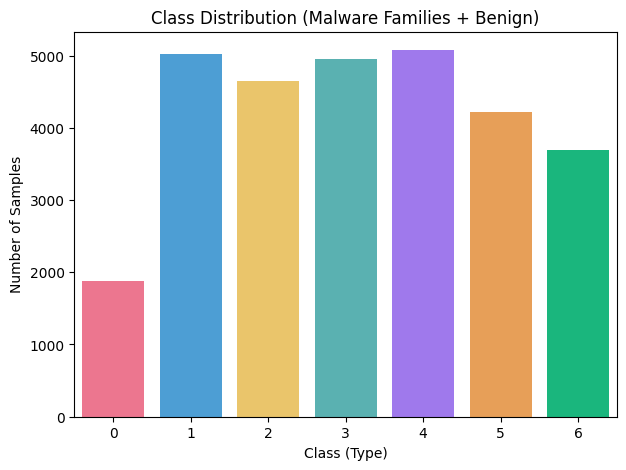

In [30]:
plt.figure(figsize=(7,5))
palette = ['#FF6384', '#36A2EB', '#FFCE56', '#4BC0C0', '#9966FF', '#FF9F40', '#00D084']
sns.countplot(data=merged_df, x='Type', palette=palette)
plt.title("Class Distribution (Malware Families + Benign)")
plt.xlabel("Class (Type)")
plt.ylabel("Number of Samples")
plt.show()

### Determine which of the following features are the most relevant to the malware type

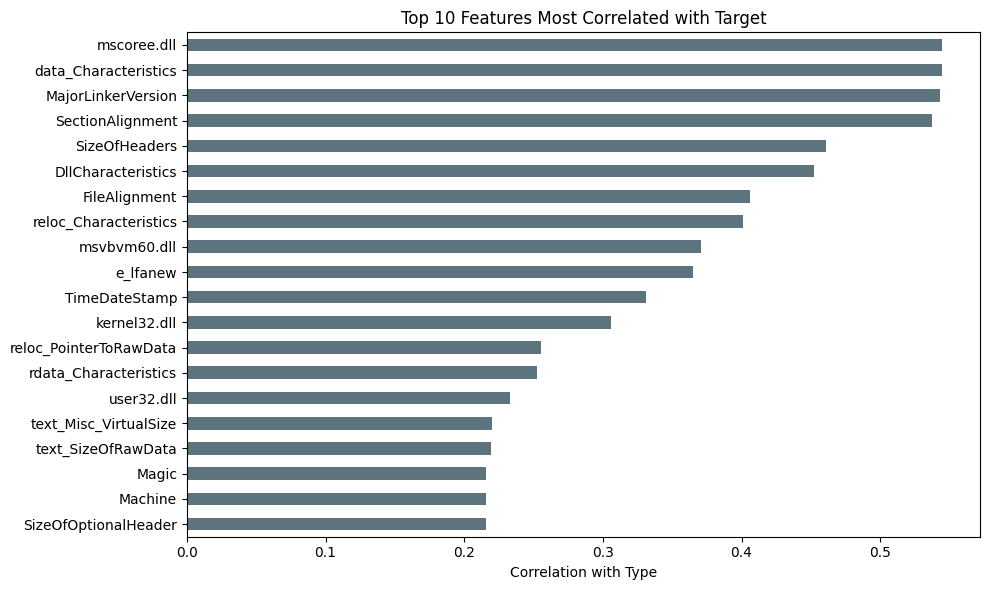

                   Feature  Absolute Correlation with Type
0              mscoree.dll                        0.544789
1     data_Characteristics                        0.544466
2       MajorLinkerVersion                        0.543057
3         SectionAlignment                        0.537731
4            SizeOfHeaders                        0.461284
5       DllCharacteristics                        0.452192
6            FileAlignment                        0.406408
7    reloc_Characteristics                        0.401002
8             msvbvm60.dll                        0.370741
9                 e_lfanew                        0.365319
10           TimeDateStamp                        0.331393
11            kernel32.dll                        0.305799
12  reloc_PointerToRawData                        0.255137
13   rdata_Characteristics                        0.252158
14              user32.dll                        0.232951
15   text_Misc_VirtualSize                        0.2199

In [31]:
# Select numeric columns only (excluding SHA256 and Type)
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Type', 'SHA256']]

# Compute correlation with the target
merged_df_corr = merged_df.copy()
merged_df_corr['Type'] = merged_df_corr['Type'].astype(int)

corr_with_label = merged_df_corr[numeric_cols + ['Type']].corr()['Type'].drop('Type')
top_corr = corr_with_label.abs().sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
top_corr.plot(kind='barh', color='#5D737E')
plt.title("Top 10 Features Most Correlated with Target")
plt.xlabel("Correlation with Type")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# View + export numerical data of top 10 features
top_corr_df = top_corr.reset_index()
top_corr_df.columns = ['Feature', 'Absolute Correlation with Type']
print(top_corr_df)

### Visualize Class-wise Trends of Top Correlated Features as shown from previous code block
This section analyzes how the top correlated features behave across different malware types (including benign samples) by plotting their class-wise mean values. This visualization helps detect distinctive trends or patterns in feature behavior across malware families. 

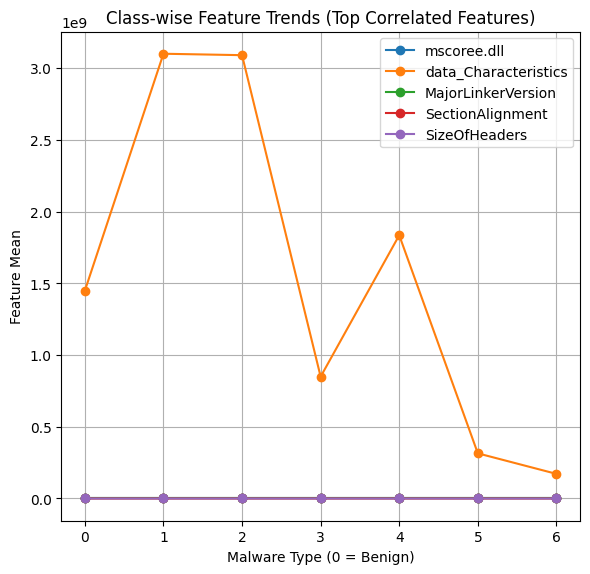

In [32]:
top_corr_features = ['mscoree.dll', 'data_Characteristics', 'MajorLinkerVersion', 'SectionAlignment', 'SizeOfHeaders']

# Compute class-wise means
line_df = merged_df.groupby('Type')[top_corr_features].mean().T

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
for feature in line_df.index:
    plt.plot(line_df.columns, line_df.loc[feature], marker='o', label=feature)

plt.title("Class-wise Feature Trends (Top Correlated Features)")
plt.xlabel("Malware Type (0 = Benign)")
plt.ylabel("Feature Mean")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Importance Ranking with ExtraTreesClassifier and Dataset Reduction

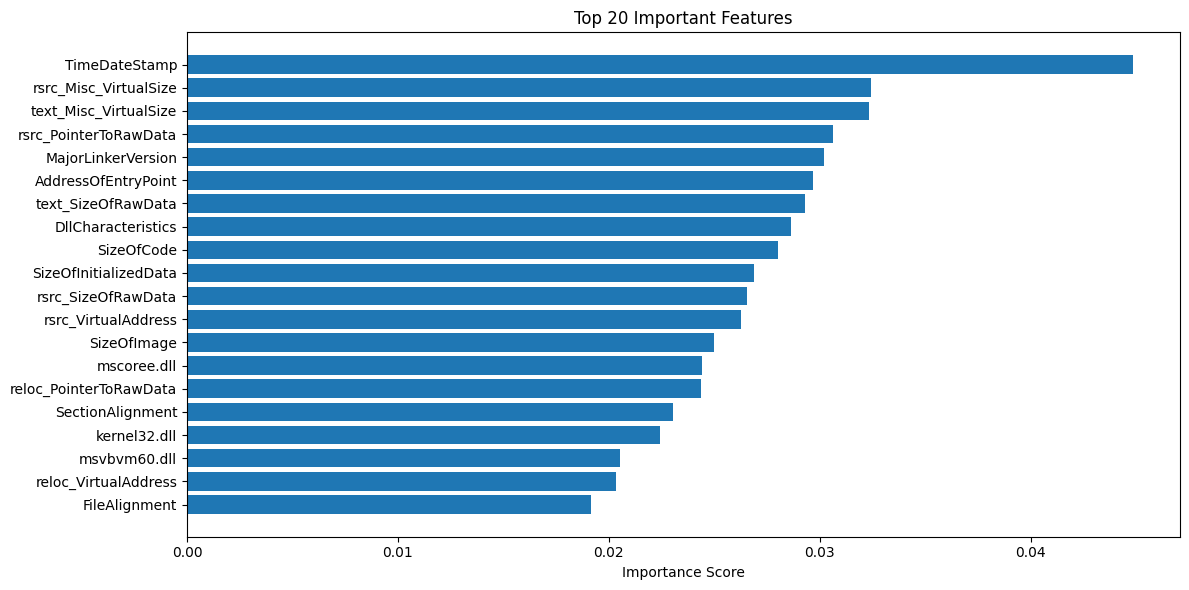

✅ Reduced dataset saved with shape: (29492, 202)


In [33]:
# Separate features and label
X = merged_df.drop(columns=['SHA256', 'Type'])  # Drop ID and label
y = merged_df['Type']

# Train ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create DataFrame for easier sorting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize top 20 features
plt.figure(figsize=(12,6))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

# Select top 200 features 
N = 200
top_features = feat_imp_df['Feature'].head(N).tolist()

# Create reduced dataset
reduced_df = merged_df[['SHA256', 'Type'] + top_features]
print(f"✅ Reduced dataset saved with shape: {reduced_df.shape}")

### Removing Perfectly Correlated Features
To avoid multicollinearity and redundant information, we identify feature pairs with perfect correlation (correlation = 1.0). 'SHA256' (unique identifier) and 'Type' (target) columns are excluded from correlation analysis as they are non-feature columns.

In [34]:
# Remove 'SHA256' and 'Type' from correlation calculation
X_reduced = reduced_df.drop(columns=['SHA256', 'Type'])

# Compute absolute correlation matrix
corr_matrix = X_reduced.corr().abs()

# Find all feature pairs with correlation = 1.0
perfect_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] == 1.0:
            perfect_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Choose one feature from each pair to drop 
to_drop = set(pair[1] for pair in perfect_corr_pairs)  

print(f" Found and dropping {len(to_drop)} perfectly correlated features...")

# Drop them from reduced_df
cleaned_df = reduced_df.drop(columns=to_drop)
print("\nCleaned shape: ", cleaned_df.shape)

 Found and dropping 5 perfectly correlated features...

Cleaned shape:  (29492, 197)


### Reperforming EDA on Cleaned Dataset 

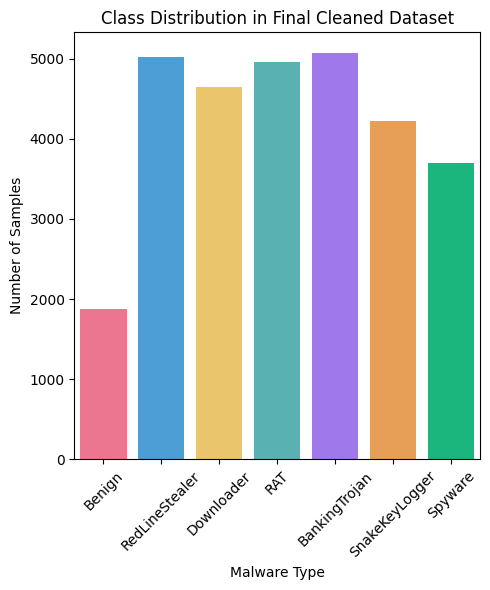

   Type       ClassName  Count
0     0          Benign   1877
1     1  RedLineStealer   5022
2     2      Downloader   4643
3     3             RAT   4955
4     4   BankingTrojan   5076
5     5  SnakeKeyLogger   4220
6     6         Spyware   3699


In [35]:
# Step 1: Mapping
class_map = {
    0: 'Benign',
    1: 'RedLineStealer',
    2: 'Downloader',
    3: 'RAT',
    4: 'BankingTrojan',
    5: 'SnakeKeyLogger',
    6: 'Spyware'
}

# Step 2: Get value counts from your final DataFrame (make sure 'Type' column exists)
class_counts = cleaned_df['Type'].value_counts().sort_index()

# Step 3: Create DataFrame for plotting
plot_df = pd.DataFrame({
    'ClassName': [class_map[i] for i in class_counts.index],
    'Count': class_counts.values
})

# Step 4: Plot
plt.figure(figsize=(5, 6))
palette = ['#FF6384', '#36A2EB', '#FFCE56', '#4BC0C0', '#9966FF', '#FF9F40', '#00D084']
sns.barplot(data=plot_df, x='ClassName', y='Count', palette=palette)
plt.title("Class Distribution in Final Cleaned Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Malware Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Tabular view
class_dist_df = pd.DataFrame({
    'Type': class_counts.index,
    'ClassName': [class_map[i] for i in class_counts.index],
    'Count': class_counts.values
})

print(class_dist_df)

---------- IGNORE THIS ----------

###### sns.set(style="whitegrid", palette="gray")

# Pick top 5 features from previous feature importance dataframe
top5 = feat_imp_df['Feature'].head(5).tolist()

# Melt the data for seaborn
melt_df = cleaned_df[['Type'] + top5].copy()
melt_df['Type'] = melt_df['Type'].map(class_map)  # Use class names

# Plot histograms
for feature in top5:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=melt_df, x=feature, hue='Type', bins=50, kde=False, element="step", palette="gray", common_norm=False)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### Previewing the Cleaned DataFrame
Display the first few rows of the cleaned DataFrame after removing perfectly correlated features to verify the resulting dataset structure.

In [36]:
cleaned_df.head()

,SHA256,Type,TimeDateStamp,rsrc_Misc_VirtualSize,text_Misc_VirtualSize,rsrc_PointerToRawData,MajorLinkerVersion,AddressOfEntryPoint,text_SizeOfRawData,DllCharacteristics,...,msvcp120.dll,opengl32.dll,api-ms-win-core-localization-l1-2-1.dll,api-ms-win-core-handle-l1-1-0.dll,wsnmp32.dll,msvcr100.dll,edata_PointerToRawData,api-ms-win-crt-string-l1-1-0.dll,edata_VirtualAddress,olepro32.dll
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1343337794,1488,260019,378368,11,157032,260096,33120,...,0,0,0,0,0,0,0,0,0,0
1,2a053f32b1d48539e3e2807f86754be87ce95b08378467...,0,1343345231,11604,62724,68608,11,64769,62976,33088,...,0,0,0,0,0,0,0,0,0,0
2,2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...,0,1436499272,4920,18329,29696,12,20128,18432,49632,...,0,0,0,0,0,0,0,0,0,0
3,308e8bb2e8a3b67607d2454370e0b50147b42049bda813...,0,1328933601,2088,64637,69632,10,21932,65024,33088,...,0,0,0,0,0,1,0,0,0,0
4,31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...,0,1343345240,1476,92540,98816,11,94052,92672,33088,...,0,0,0,0,0,0,0,0,0,0


### Visualizing Feature Correlations of Cleaned Dataset with Heatmap
After removing non-feature columns ('SHA256', 'Type'), compute the correlation matrix of remaining features. Use seaborn's heatmap to visualize correlations between features, helping identify strong relationships.

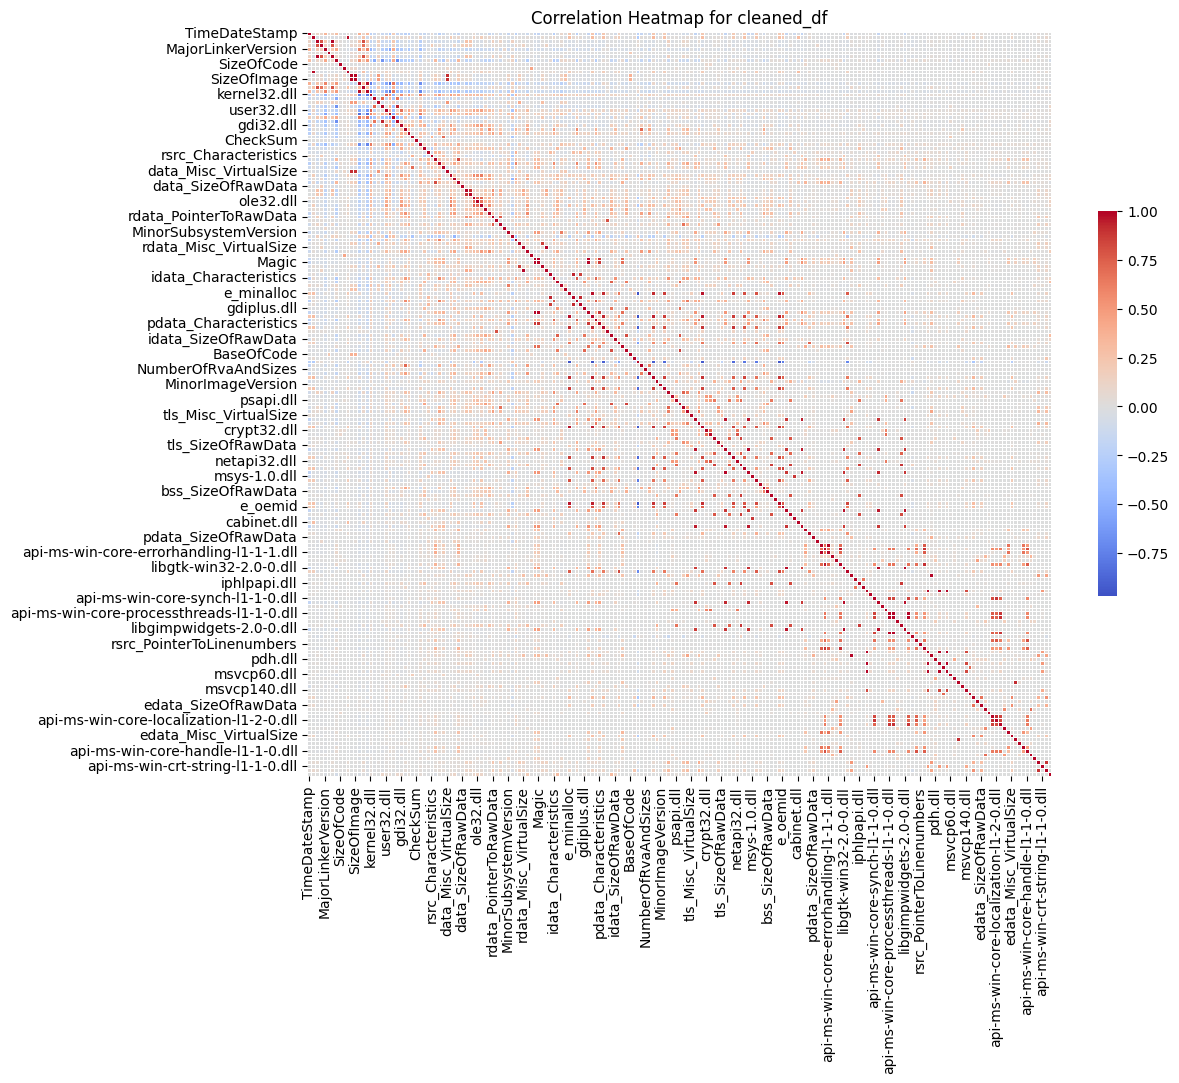

In [37]:
clean = cleaned_df.drop(columns = ['SHA256', 'Type'])

# Compute correlation matrix
corr_matrix = clean.corr()

# Set up the matplotlib figure size
plt.figure(figsize=(12, 10))  # Adjust size for clarity

# Draw the heatmap with seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

plt.title('Correlation Heatmap for cleaned_df')
plt.show()

### Boxplots of Top Numeric Features by Malware Type
Select the first 6 numeric features to visualize their distribution across different malware types using boxplots. This helps to understand feature
variability and detect class-wise differences.

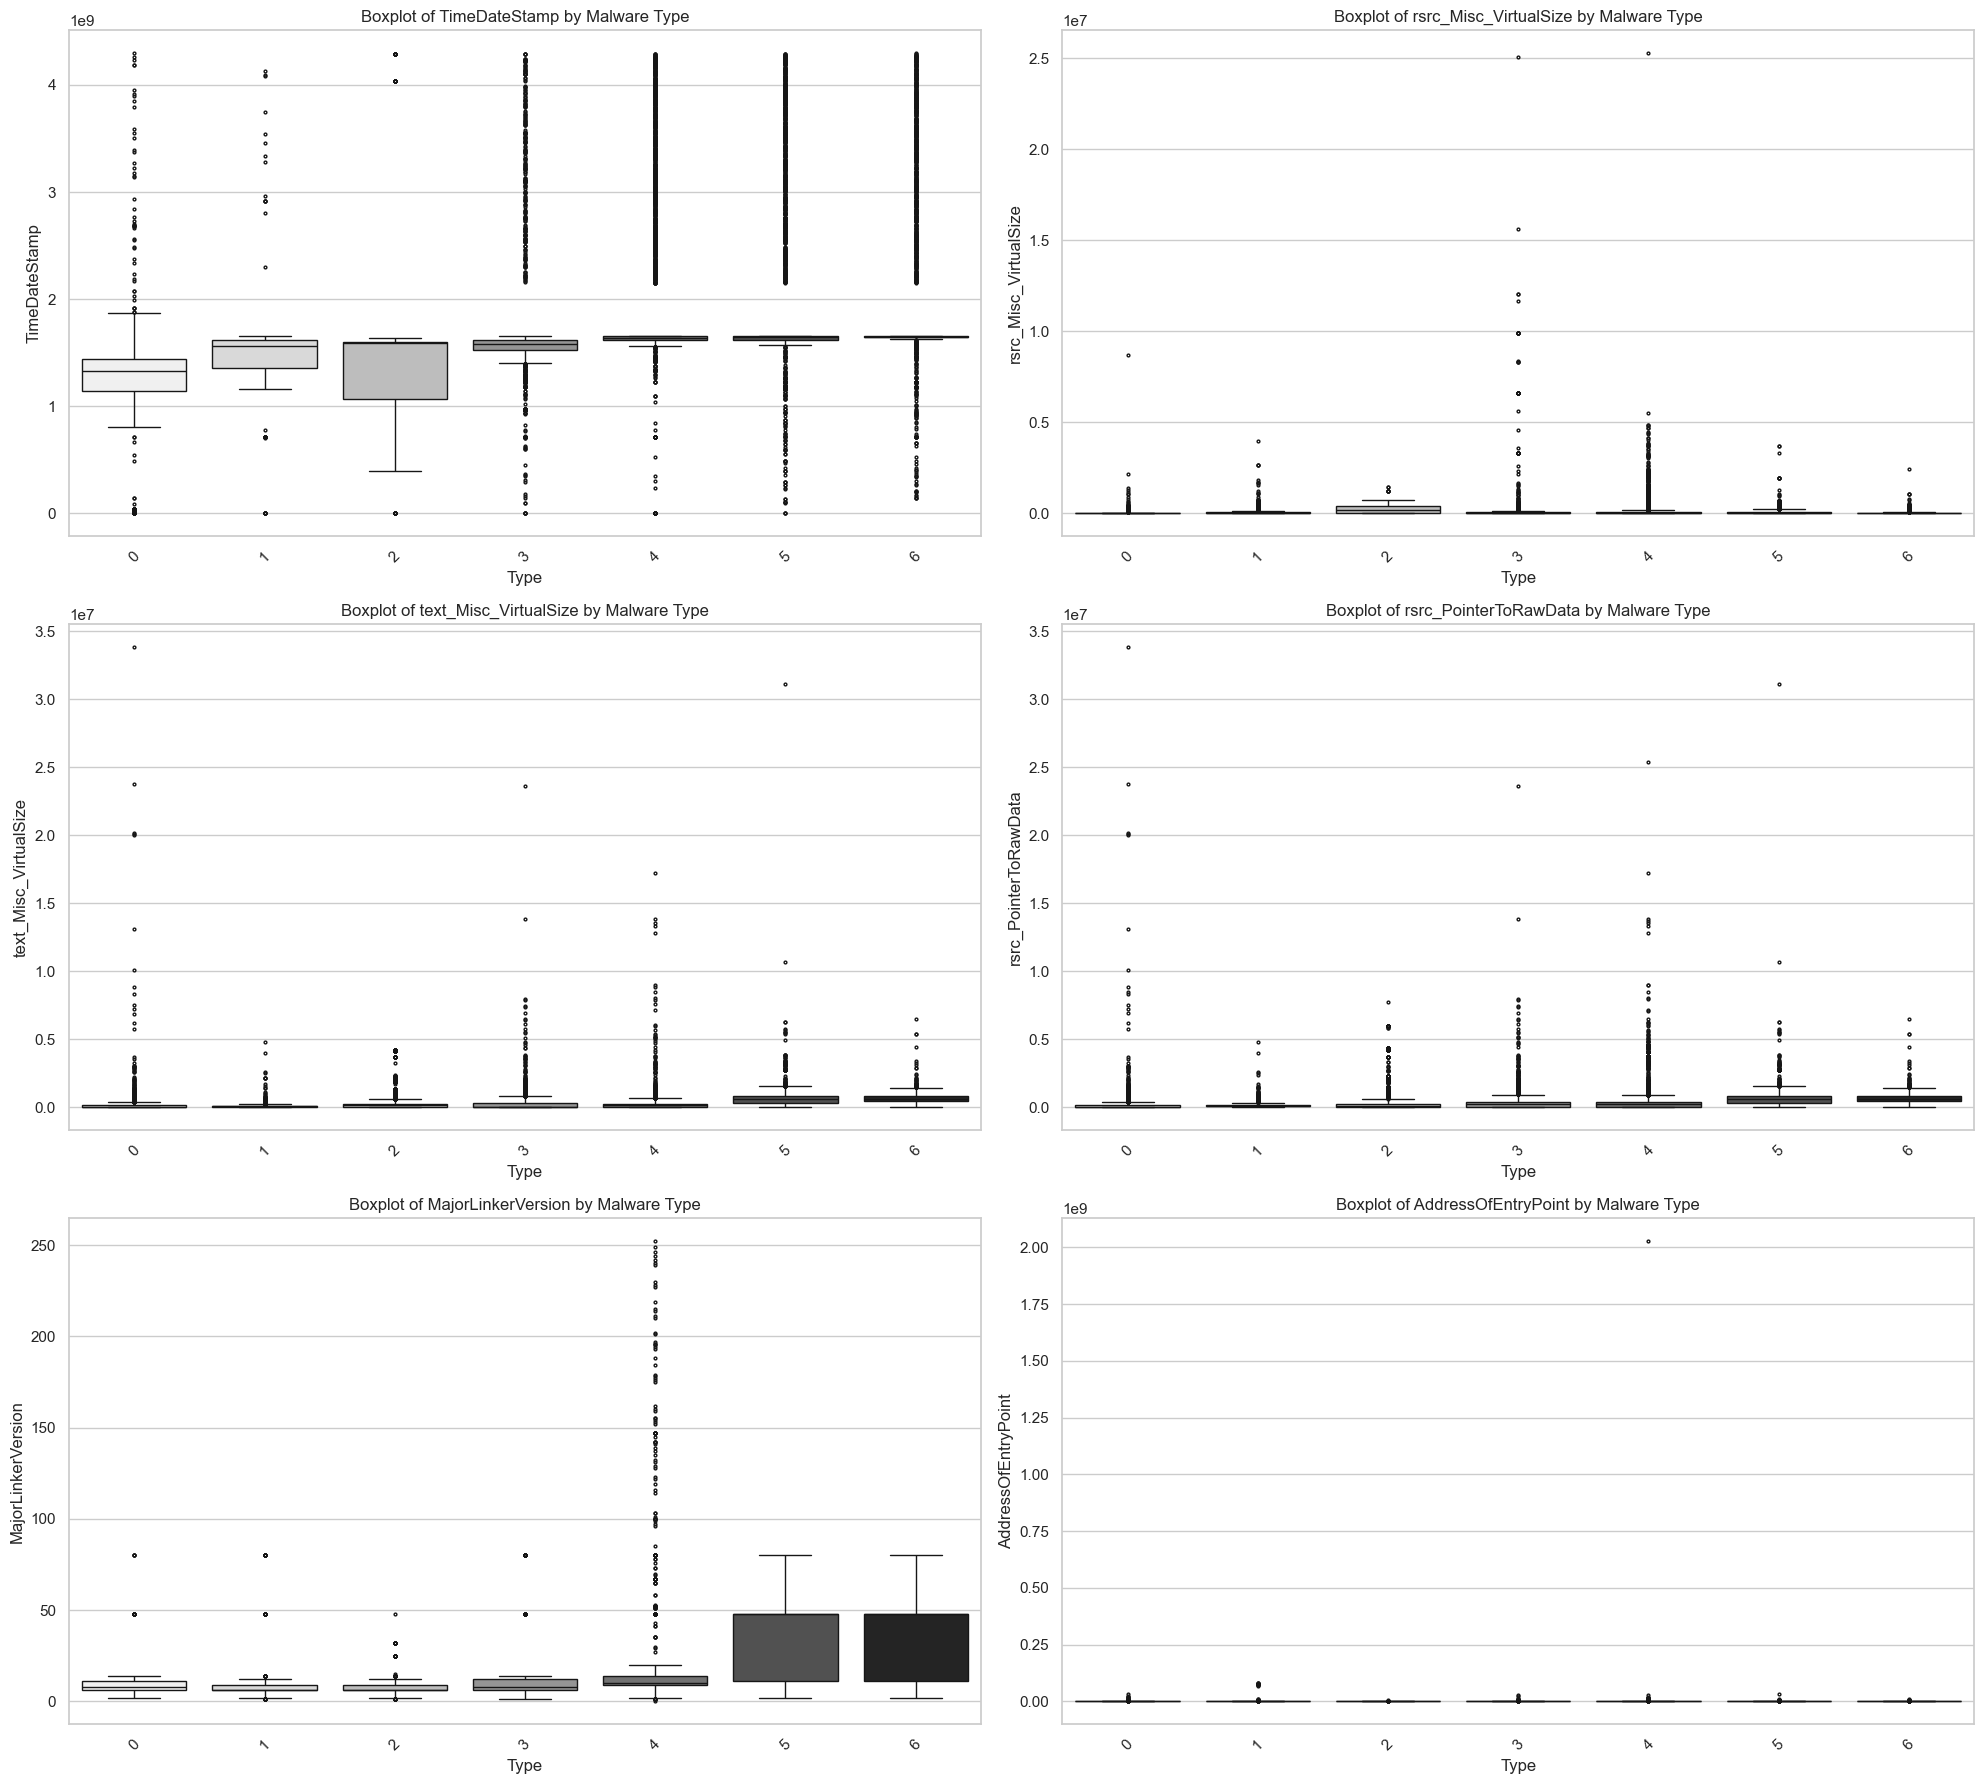

In [38]:
top_numeric = cleaned_df.drop(columns=['SHA256', 'Type']).columns[:6] 

# Set gray theme for cleaner visualization
sns.set_theme(style="whitegrid", palette="gray")

# Plot boxplots for each selected feature grouped by 'Type'
plt.figure(figsize=(20, 18))
for i, feature in enumerate(top_numeric, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=cleaned_df, x='Type', y=feature, palette="Greys", fliersize=2, linewidth=1)
    plt.title(f"Boxplot of {feature} by Malware Type")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Processing `api_dll`

### Exploring the API Functions Dataset
Print the shape to understand the dataset siz eand display the first 10 rows to preview its structure and content, useful for initial data inspection.

In [39]:
print(" Shape of API data:", api_df.shape)
print("Top 10 rows:")
api_df.head(10)

 Shape of API data: (29505, 21920)
Top 10 rows:


,SHA256,Type,getaclinformation,getace,getsecuritydescriptordacl,regqueryvalueexa,regopenkeyexa,getsecurityinfo,isvalidsid,regclosekey,...,drawdibclose,ord1107,wsasetblockinghook,setupinstallfileexa,setupterminatefilelog,setuplogfilew,setupopenmasterinf,setupinstallfileexw,setupgetlinecountw,setupdigethwprofilefriendlynameexw
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b350fac81533f02981dc2176ed17163177d92d9405758e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dfee618043a47b7b09305df0ca460559d9f567ee246c7b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,a36878ce723af818246c98ad08e38b83686c7e9267f244...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,c8deef6eb5744a1fed083051d7bf4a699c5880ee13f343...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,d3e4d6dd3e427229e5c8fd2409dbef6d28356a163ead6e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,afbae9a4b2e4c0e04dc7f7b5c8eba539bcaea91363a544...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Analysis of API Functions Dataset

In [40]:
# Number of unique values in the first 10 feature columns (excluding index)
print("\nNumber of unique values in first 10 columns:")
print(api_df.iloc[:, 1:11].nunique())

# Identify columns that are constant (only one unique value)
constant_cols = [col for col in api_df.columns if api_df[col].nunique() == 1]
print(f"\nConstant Columns: {len(constant_cols)}")

# Identify columns that are binary (only contain 0 or 1)
binary_cols = [
    col for col in api_df.columns if set(api_df[col].unique()).issubset({0, 1})
]
print(f"Binary Columns: {len(binary_cols)}")

# Check for exact duplicate columns in the dataset
dup_cols = api_df.T.duplicated()
print(f"Duplicate Columns: {dup_cols.sum()}")

# Check for any missing/null values in the entire DataFrame
print(f"\nNull values? {api_df.isnull().sum().sum()}")


Number of unique values in first 10 columns:
Type                          7
getaclinformation             2
getace                        2
getsecuritydescriptordacl     2
regqueryvalueexa              2
regopenkeyexa                 2
getsecurityinfo               2
isvalidsid                    2
regclosekey                   2
getexplicitentriesfromacla    2
dtype: int64

Constant Columns: 0
Binary Columns: 21918
Duplicate Columns: 15295

Null values? 0


## Data Processing for `api_df`

### Cleaning API Functions DataFrame
1. Remove exact duplicate columns to reduce redundancy by transposing the DataFrame and using duplicated().
2. Drop the 'Type' column if present, since it is already available in the DLLs dataset to avoid duplication.
3. Print the new shape to confirm cleaning results.

In [41]:
# Drop duplicate columns (transpose + duplicated)
api_df_cleaned = api_df.loc[:, ~api_df.T.duplicated()]

# Drop 'Type' column (already in DLLs file)
if 'Type' in api_df_cleaned.columns:
    api_df_cleaned = api_df_cleaned.drop(columns=['Type'])

# Confirm shape
print(" Cleaned API shape:", api_df_cleaned.shape)

 Cleaned API shape: (29505, 6624)


### Feature Selection Using ExtraTreesClassifier
1. Separate features and labels by dropping 'SHA256' and 'Type'.
2. Train an ExtraTreesClassifier to estimate feature importances.
3. Select the top 200 features based on importance scores.
4. Create a new DataFrame containing 'SHA256' and the selected features.
5. Print the shape of the resulting DataFrame.

In [42]:
# Drop 'Type' and 'SHA256' to get features
api_features = api_df.drop(columns=['SHA256', 'Type'])
api_labels = api_df['Type']

# Initialize and fit the ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
etc.fit(api_features, api_labels)

# Get feature importances from the trained model
importances = etc.feature_importances_

# Select indices of top 200 features sorted by importance
top_k = 200
top_k_indices = importances.argsort()[::-1][:top_k]

# Retrieve column names corresponding to top features
top_k_columns = api_features.columns[top_k_indices]

# Create DataFrame with 'SHA256' and top features
api_topk_df = api_df[['SHA256'] + list(top_k_columns)]

print("Top 200 API Features shape:", api_topk_df.shape)

Top 200 API Features shape: (29505, 201)


## Merge cleaned api_dll with cleaned_df
Final dataset to be used for model training should be `final_df`

In [43]:
final_df = cleaned_df.merge(api_topk_df, on='SHA256', how='left')

print("Final merged shape:", final_df.shape)

Final merged shape: (29497, 397)


### Handling Missing Values in final_df

In [44]:
null = final_df.isnull().sum().sum()
final_df = final_df.dropna()
print("Number of null values: ", null)

Number of null values:  600


### Removing Columns Without Variance

In [45]:
var = final_df.apply(lambda x : x.nunique())

# Find columns with only 1 unique value
cols_to_drop = var[var == 1].index.tolist()

# Drop them from the DataFrame
final_df = final_df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} columns without variance.")
print("Final shape:", final_df.shape)

Dropped 0 columns without variance.
Final shape: (29494, 397)


### Previewing the Final Cleaned DataFrame
Display the first few rows of the final dataset after all cleaning steps to verify the structure and data consistency before modeling.

In [46]:
final_df.head()

,SHA256,Type,TimeDateStamp,rsrc_Misc_VirtualSize,text_Misc_VirtualSize,rsrc_PointerToRawData,MajorLinkerVersion,AddressOfEntryPoint,text_SizeOfRawData,DllCharacteristics,...,cisin,lstrlena,lstrlenw,vbaobjset,openprocesstoken,sendnotifymessagea,decodepointer,getmapmode,movefilew,getsystemtimeasfiletime
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,0,1343337794,1488,260019,378368,11,157032,260096,33120,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,2a053f32b1d48539e3e2807f86754be87ce95b08378467...,0,1343345231,11604,62724,68608,11,64769,62976,33088,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2f031a1752f7067fb9f483ae0ac5f3036c9b66cc4af40e...,0,1436499272,4920,18329,29696,12,20128,18432,49632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,308e8bb2e8a3b67607d2454370e0b50147b42049bda813...,0,1328933601,2088,64637,69632,10,21932,65024,33088,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,31aaba443b9869e6e68c17125f8d7989cbd762fb38ae3a...,0,1343345240,1476,92540,98816,11,94052,92672,33088,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Display all Malware Types from `final_df`
Malware Type / family Labels:
- 0 = Benign
- 1 = RedLineStealer
- 2 = Downloader
- 3 = RAT
- 4 = BankingTrojan
- 5 = SnakeKeyLogger
- 6 = Spyware

In [47]:
final_df['Type'].value_counts()

Type
4    5076
1    5022
3    4955
2    4643
5    4222
6    3699
0    1877
Name: count, dtype: int64

## Predictive Modelling

## Splitting Data into Training, Validation, and Test Sets

In [48]:
X = final_df.drop(columns=['SHA256', 'Type'])  # Separate features from identifiers and target
y = final_df['Type']                           # Target labels

# Split data: 60% train, 40% remain for validation and test
X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size=0.6, random_state=42)

# Split remaining 40% equally into validation (20%) and test (20%)
X_validate, X_test, y_validate, y_test = train_test_split(X_remain, y_remain, train_size=0.5, random_state=42)

### Computing Class Weights to Handle Imbalanced Classes

In [49]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)  # Get unique class labels from training set

# Compute balanced class weights inversely proportional to class frequencies
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Create dictionary mapping each class label to its corresponding weight
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)  # Display class weights for reference

{0: 2.2194907813871816, 1: 0.8393094289508632, 2: 0.9093525179856116, 3: 0.867833848266392, 4: 0.8199805384365877, 5: 0.996059889676911, 6: 1.1331241595696997}


In [50]:
# Create an array of sample weights for each training instance
# by mapping each label in y_train to its corresponding class weight.
sample_weights = np.array([class_weight_dict[label] for label in y_train])

### Training an XGBoost Multi-class Classifier

In [51]:
num_classes = len(set(y))  # Determine number of unique classes for classification

# Initialize XGBClassifier with multi-class objective and relevant parameters
model = XGBClassifier(
    objective='multi:softmax',          # Multi-class classification with softmax output
    num_class=num_classes,              # Number of classes
    missing=1,                         # Placeholder for missing values
    early_stopping_rounds=10,          # Stop training if no improvement after 10 rounds
    eval_metric=['merror', 'mlogloss'],# Evaluation metrics: classification error and log loss
    seed=42                           # For reproducibility
)

# Train the model with training data, sample weights, and validation set for early stopping
model.fit(
    X_train,
    y_train,
    verbose=0,                        # Set to 1 to show training progress
    sample_weight=sample_weights,    # Handle class imbalance with sample weights
    eval_set=[(X_train, y_train), (X_validate, y_validate)]  # Monitor training and validation metrics
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=1, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7, ...)

### Plotting XGBoost Training and Validation Metrics

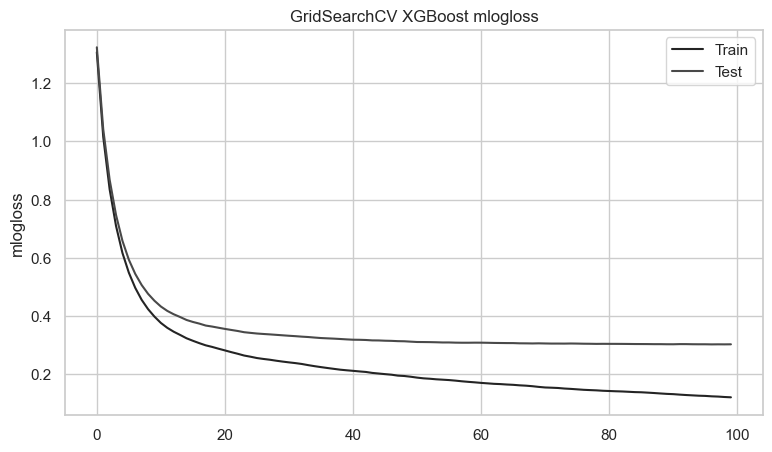

Final validation multi-class logarithmic loss: 0.30229792922350635


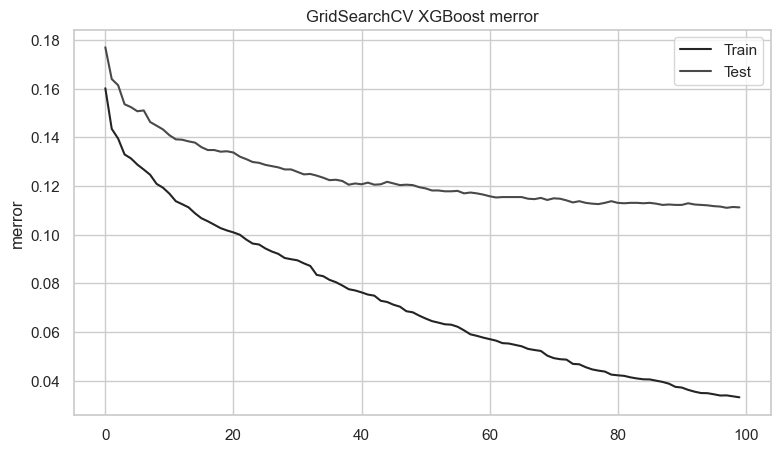

Final validation multi-class classification error rate: 0.11120528903203933


In [52]:
results = model.evals_result()               # Retrieve training evaluation results
epochs = len(results['validation_0']['mlogloss'])  # Number of training epochs
x_axis = range(0, epochs)                     # Epoch indices for plotting

# Plot multi-class logarithmic loss (mlogloss) over epochs
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# Print final validation log loss
print(f"Final validation multi-class logarithmic loss: {results['validation_1']['mlogloss'][-1]}")

# Plot multi-class classification error rate (merror) over epochs
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

# Print final validation classification error rate
print(f"Final validation multi-class classification error rate: {results['validation_1']['merror'][-1]}")

### Confusion Matrix for Validation Set Predictions

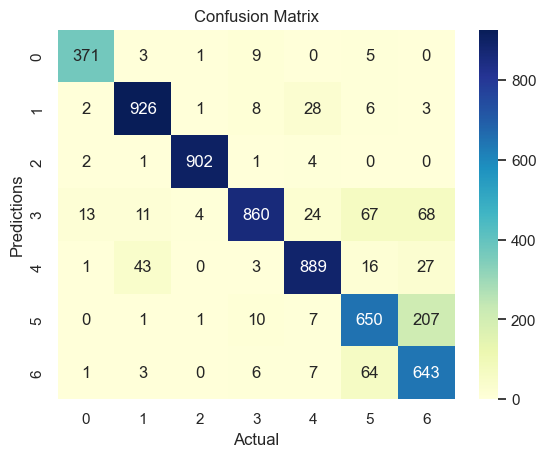

In [53]:
pred_validate = model.predict(X_validate)  # Predict labels on validation data

# Compute confusion matrix: actual vs predicted
cm = confusion_matrix(y_validate, pred_validate)

# Plot confusion matrix heatmap with annotations
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu', 
    xticklabels=final_df['Type'].unique(),  # Actual classes on x-axis
    yticklabels=final_df['Type'].unique()   # Predicted classes on y-axis
)

plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Classification Report for Validation Predictions

In [54]:
print(classification_report(y_validate, pred_validate))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       389
           1       0.94      0.95      0.94       974
           2       0.99      0.99      0.99       910
           3       0.96      0.82      0.88      1047
           4       0.93      0.91      0.92       979
           5       0.80      0.74      0.77       876
           6       0.68      0.89      0.77       724

    accuracy                           0.89      5899
   macro avg       0.89      0.89      0.89      5899
weighted avg       0.90      0.89      0.89      5899



### Optuna Objective Function for Hyperparameter Tuning

In [55]:

def objective(trial):
    # Define hyperparameter search space using trial suggestions
    param = {
        'objective': 'multi:softmax',         # Multi-class softmax classification
        'num_class': num_classes,              # Number of classes
        'eval_metric': ['mlogloss', 'merror'],# Evaluation metrics
        'max_depth': trial.suggest_int('max_depth', 3, 10),               # Tree depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1), # Step size shrinkage
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),    # Number of boosting rounds
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),         # Row subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Feature subsampling
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Minimum sum of instance weight in child
        'gamma': trial.suggest_float('gamma', 0, 5),                      # Minimum loss reduction
        'verbosity': 0,                                                  # Silent mode
        'use_label_encoder': False                                       # Disable label encoding warning
    }
    
    model = XGBClassifier(**param)  # Instantiate XGBoost model with trial params
    
    # Stratified K-Fold cross-validation setup
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scores = []
    # Manual cross-validation loop to use sample weights for imbalance handling
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Compute sample weights for the training fold
        sample_weights_fold = np.array([class_weight_dict[label] for label in y_tr])
        
        # Train model on training fold
        model.fit(X_tr, y_tr, sample_weight=sample_weights_fold, verbose=False)
        
        # Evaluate accuracy on validation fold
        score = model.score(X_val, y_val)
        scores.append(score)
    
    # Return mean accuracy across folds as the objective to maximize
    return np.mean(scores)

### Running Optuna Hyperparameter Optimization

In [56]:
# Create an Optuna study object with the goal to maximize accuracy
study = optuna.create_study(direction='maximize')

# Optimize the objective function for 30 trials with progress bar
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Print the best hyperparameters found during the study
print("\nBest params:", study.best_params)

[I 2025-08-12 21:08:22,829] A new study created in memory with name: no-name-c9eacc92-e1d7-4a8e-ba24-625757de5156
Best trial: 0. Best value: 0.86658:   3%|▎         | 1/30 [01:29<43:16, 89.53s/it]

[I 2025-08-12 21:09:52,366] Trial 0 finished with value: 0.8665800459730049 and parameters: {'max_depth': 10, 'learning_rate': 0.015238149652596908, 'n_estimators': 872, 'subsample': 0.8037366295795069, 'colsample_bytree': 0.8407498610050217, 'min_child_weight': 3, 'gamma': 2.7940210639679934}. Best is trial 0 with value: 0.8665800459730049.


Best trial: 1. Best value: 0.869688:   7%|▋         | 2/30 [02:28<33:26, 71.67s/it]

[I 2025-08-12 21:10:51,533] Trial 1 finished with value: 0.869687946105626 and parameters: {'max_depth': 6, 'learning_rate': 0.03299182502486043, 'n_estimators': 648, 'subsample': 0.5305864304477346, 'colsample_bytree': 0.9929836408025373, 'min_child_weight': 2, 'gamma': 1.9877188379156374}. Best is trial 1 with value: 0.869687946105626.


Best trial: 1. Best value: 0.869688:  10%|█         | 3/30 [03:05<25:10, 55.94s/it]

[I 2025-08-12 21:11:28,765] Trial 2 finished with value: 0.8562953571358017 and parameters: {'max_depth': 5, 'learning_rate': 0.0962308478681712, 'n_estimators': 611, 'subsample': 0.8590291178007171, 'colsample_bytree': 0.9215840957610741, 'min_child_weight': 9, 'gamma': 3.527620075530687}. Best is trial 1 with value: 0.869687946105626.


Best trial: 1. Best value: 0.869688:  13%|█▎        | 4/30 [04:19<27:15, 62.90s/it]

[I 2025-08-12 21:12:42,298] Trial 3 finished with value: 0.8599683343746557 and parameters: {'max_depth': 9, 'learning_rate': 0.019853382336182716, 'n_estimators': 829, 'subsample': 0.5351250294862482, 'colsample_bytree': 0.5228418220553845, 'min_child_weight': 4, 'gamma': 3.470243342947784}. Best is trial 1 with value: 0.869687946105626.


Best trial: 1. Best value: 0.869688:  17%|█▋        | 5/30 [05:02<23:15, 55.83s/it]

[I 2025-08-12 21:13:25,615] Trial 4 finished with value: 0.867314662498235 and parameters: {'max_depth': 8, 'learning_rate': 0.09261241133993048, 'n_estimators': 681, 'subsample': 0.9935756881647431, 'colsample_bytree': 0.8476558052012062, 'min_child_weight': 3, 'gamma': 2.6274001934863493}. Best is trial 1 with value: 0.869687946105626.


Best trial: 1. Best value: 0.869688:  20%|██        | 6/30 [05:21<17:15, 43.16s/it]

[I 2025-08-12 21:13:44,187] Trial 5 finished with value: 0.8431849761862074 and parameters: {'max_depth': 3, 'learning_rate': 0.07135053292745591, 'n_estimators': 232, 'subsample': 0.7454309583345762, 'colsample_bytree': 0.7111149818177795, 'min_child_weight': 9, 'gamma': 4.012402424536538}. Best is trial 1 with value: 0.869687946105626.


Best trial: 1. Best value: 0.869688:  23%|██▎       | 7/30 [05:48<14:28, 37.78s/it]

[I 2025-08-12 21:14:10,890] Trial 6 finished with value: 0.8531308161213363 and parameters: {'max_depth': 4, 'learning_rate': 0.03587118798627088, 'n_estimators': 298, 'subsample': 0.8472453003076115, 'colsample_bytree': 0.5773438440526928, 'min_child_weight': 3, 'gamma': 3.444074414072087}. Best is trial 1 with value: 0.869687946105626.


Best trial: 1. Best value: 0.869688:  27%|██▋       | 8/30 [06:44<16:00, 43.67s/it]

[I 2025-08-12 21:15:07,174] Trial 7 finished with value: 0.8596857431278907 and parameters: {'max_depth': 4, 'learning_rate': 0.020354690909576076, 'n_estimators': 561, 'subsample': 0.5854972806950838, 'colsample_bytree': 0.6473952831593872, 'min_child_weight': 9, 'gamma': 0.7005902772854439}. Best is trial 1 with value: 0.869687946105626.


Best trial: 8. Best value: 0.8737:  30%|███       | 9/30 [07:42<16:55, 48.34s/it]  

[I 2025-08-12 21:16:05,789] Trial 8 finished with value: 0.8737001746344157 and parameters: {'max_depth': 5, 'learning_rate': 0.03770113026847928, 'n_estimators': 736, 'subsample': 0.9738740841152591, 'colsample_bytree': 0.703820086570824, 'min_child_weight': 4, 'gamma': 0.7457661220826561}. Best is trial 8 with value: 0.8737001746344157.


Best trial: 8. Best value: 0.8737:  33%|███▎      | 10/30 [08:38<16:50, 50.52s/it]

[I 2025-08-12 21:17:01,168] Trial 9 finished with value: 0.8632459463782151 and parameters: {'max_depth': 7, 'learning_rate': 0.01976803114582928, 'n_estimators': 447, 'subsample': 0.5512485379883749, 'colsample_bytree': 0.8061682677844326, 'min_child_weight': 9, 'gamma': 1.8134960979561883}. Best is trial 8 with value: 0.8737001746344157.


Best trial: 10. Best value: 0.887093:  37%|███▋      | 11/30 [10:33<22:17, 70.41s/it]

[I 2025-08-12 21:18:56,672] Trial 10 finished with value: 0.8870929360561809 and parameters: {'max_depth': 6, 'learning_rate': 0.05461253835386069, 'n_estimators': 986, 'subsample': 0.9359234520994103, 'colsample_bytree': 0.7003060373324329, 'min_child_weight': 6, 'gamma': 0.09175339895448464}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  40%|████      | 12/30 [11:45<21:15, 70.86s/it]

[I 2025-08-12 21:20:08,558] Trial 11 finished with value: 0.8772602533361163 and parameters: {'max_depth': 6, 'learning_rate': 0.05566702179739935, 'n_estimators': 976, 'subsample': 0.9980141786753641, 'colsample_bytree': 0.7021359065940355, 'min_child_weight': 6, 'gamma': 0.3616472192607137}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  43%|████▎     | 13/30 [13:41<23:57, 84.56s/it]

[I 2025-08-12 21:22:04,652] Trial 12 finished with value: 0.8867538955408394 and parameters: {'max_depth': 7, 'learning_rate': 0.061020897942219474, 'n_estimators': 1000, 'subsample': 0.9190791119115862, 'colsample_bytree': 0.6232533764790555, 'min_child_weight': 6, 'gamma': 0.11037176950546095}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  47%|████▋     | 14/30 [15:54<26:24, 99.01s/it]

[I 2025-08-12 21:24:17,043] Trial 13 finished with value: 0.886866803658656 and parameters: {'max_depth': 8, 'learning_rate': 0.06515503767263434, 'n_estimators': 994, 'subsample': 0.9106514997513514, 'colsample_bytree': 0.6110605208773294, 'min_child_weight': 7, 'gamma': 0.03987317064172449}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  50%|█████     | 15/30 [17:01<22:21, 89.46s/it]

[I 2025-08-12 21:25:24,375] Trial 14 finished with value: 0.8768646198422475 and parameters: {'max_depth': 8, 'learning_rate': 0.07297401776634006, 'n_estimators': 874, 'subsample': 0.707123905070179, 'colsample_bytree': 0.5234009452170751, 'min_child_weight': 7, 'gamma': 1.2903742963516556}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  53%|█████▎    | 16/30 [17:34<16:53, 72.41s/it]

[I 2025-08-12 21:25:57,177] Trial 15 finished with value: 0.8592338519787126 and parameters: {'max_depth': 8, 'learning_rate': 0.07587758853283122, 'n_estimators': 435, 'subsample': 0.9139437857170776, 'colsample_bytree': 0.7660329394814032, 'min_child_weight': 7, 'gamma': 4.789642798419382}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  57%|█████▋    | 17/30 [18:39<15:12, 70.18s/it]

[I 2025-08-12 21:27:02,187] Trial 16 finished with value: 0.8785600331935495 and parameters: {'max_depth': 10, 'learning_rate': 0.048158569526607194, 'n_estimators': 793, 'subsample': 0.9062438778801277, 'colsample_bytree': 0.6200802539844841, 'min_child_weight': 7, 'gamma': 1.1590619540620346}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  60%|██████    | 18/30 [19:00<11:06, 55.50s/it]

[I 2025-08-12 21:27:23,518] Trial 17 finished with value: 0.8834764368278937 and parameters: {'max_depth': 9, 'learning_rate': 0.08468451147321132, 'n_estimators': 117, 'subsample': 0.7050516007479288, 'colsample_bytree': 0.5723129335774269, 'min_child_weight': 5, 'gamma': 0.05402985828130981}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  63%|██████▎   | 19/30 [20:03<10:33, 57.63s/it]

[I 2025-08-12 21:28:26,108] Trial 18 finished with value: 0.8748304150728514 and parameters: {'max_depth': 7, 'learning_rate': 0.064041640893963, 'n_estimators': 941, 'subsample': 0.8039767546263721, 'colsample_bytree': 0.6620050677971014, 'min_child_weight': 1, 'gamma': 1.4929142207591353}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  67%|██████▋   | 20/30 [21:21<10:37, 63.78s/it]

[I 2025-08-12 21:29:44,202] Trial 19 finished with value: 0.8788425861176609 and parameters: {'max_depth': 5, 'learning_rate': 0.04789789538345367, 'n_estimators': 767, 'subsample': 0.6359138787361454, 'colsample_bytree': 0.7477483862291883, 'min_child_weight': 8, 'gamma': 0.7962581749628549}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  70%|███████   | 21/30 [22:19<09:19, 62.21s/it]

[I 2025-08-12 21:30:42,762] Trial 20 finished with value: 0.8679362463570245 and parameters: {'max_depth': 9, 'learning_rate': 0.04768113585205278, 'n_estimators': 896, 'subsample': 0.9420442882124539, 'colsample_bytree': 0.5870787267871146, 'min_child_weight': 10, 'gamma': 2.0135479559443694}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  73%|███████▎  | 22/30 [24:23<10:45, 80.72s/it]

[I 2025-08-12 21:32:46,646] Trial 21 finished with value: 0.8863017169717601 and parameters: {'max_depth': 7, 'learning_rate': 0.05971095221276413, 'n_estimators': 994, 'subsample': 0.877313586291768, 'colsample_bytree': 0.6460616369382159, 'min_child_weight': 6, 'gamma': 0.101382336722614}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  77%|███████▋  | 23/30 [25:34<09:03, 77.67s/it]

[I 2025-08-12 21:33:57,209] Trial 22 finished with value: 0.8829678664742179 and parameters: {'max_depth': 6, 'learning_rate': 0.06502375703387464, 'n_estimators': 991, 'subsample': 0.930542999287332, 'colsample_bytree': 0.5908025053443048, 'min_child_weight': 5, 'gamma': 0.4538915637317479}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  80%|████████  | 24/30 [27:38<09:08, 91.47s/it]

[I 2025-08-12 21:36:00,879] Trial 23 finished with value: 0.885623511392453 and parameters: {'max_depth': 8, 'learning_rate': 0.08336367546092067, 'n_estimators': 904, 'subsample': 0.8165683763058769, 'colsample_bytree': 0.5011391786810655, 'min_child_weight': 6, 'gamma': 0.026164319287867804}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  83%|████████▎ | 25/30 [28:38<06:50, 82.09s/it]

[I 2025-08-12 21:37:01,069] Trial 24 finished with value: 0.8756215575119654 and parameters: {'max_depth': 7, 'learning_rate': 0.05333907887437962, 'n_estimators': 829, 'subsample': 0.9570730109680464, 'colsample_bytree': 0.676614090659012, 'min_child_weight': 8, 'gamma': 0.9768017580534979}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  87%|████████▋ | 26/30 [29:59<05:27, 81.84s/it]

[I 2025-08-12 21:38:22,333] Trial 25 finished with value: 0.883702320128171 and parameters: {'max_depth': 6, 'learning_rate': 0.06811941233554829, 'n_estimators': 946, 'subsample': 0.8883031510151909, 'colsample_bytree': 0.7359856958875175, 'min_child_weight': 5, 'gamma': 0.3753377100987185}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  90%|█████████ | 27/30 [30:34<03:23, 67.69s/it]

[I 2025-08-12 21:38:56,992] Trial 26 finished with value: 0.8711008065328167 and parameters: {'max_depth': 7, 'learning_rate': 0.0832827959783384, 'n_estimators': 470, 'subsample': 0.7591632275312132, 'colsample_bytree': 0.6161947245713395, 'min_child_weight': 7, 'gamma': 1.660447615165934}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  93%|█████████▎| 28/30 [31:53<02:22, 71.07s/it]

[I 2025-08-12 21:40:15,966] Trial 27 finished with value: 0.8839850838268765 and parameters: {'max_depth': 8, 'learning_rate': 0.04138555091865027, 'n_estimators': 690, 'subsample': 0.8427775898369706, 'colsample_bytree': 0.5549679412328918, 'min_child_weight': 8, 'gamma': 0.43773472156604265}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093:  97%|█████████▋| 29/30 [32:54<01:08, 68.12s/it]

[I 2025-08-12 21:41:17,190] Trial 28 finished with value: 0.8772039286161634 and parameters: {'max_depth': 9, 'learning_rate': 0.05722257086544322, 'n_estimators': 828, 'subsample': 0.9513468109667373, 'colsample_bytree': 0.7757992999829768, 'min_child_weight': 6, 'gamma': 1.0868425927755105}. Best is trial 10 with value: 0.8870929360561809.


Best trial: 10. Best value: 0.887093: 100%|██████████| 30/30 [33:50<00:00, 67.69s/it]

[I 2025-08-12 21:42:13,431] Trial 29 finished with value: 0.8649411968582399 and parameters: {'max_depth': 5, 'learning_rate': 0.07753480036126743, 'n_estimators': 913, 'subsample': 0.776484937652359, 'colsample_bytree': 0.6342215019716966, 'min_child_weight': 4, 'gamma': 2.292764872715475}. Best is trial 10 with value: 0.8870929360561809.

Best params: {'max_depth': 6, 'learning_rate': 0.05461253835386069, 'n_estimators': 986, 'subsample': 0.9359234520994103, 'colsample_bytree': 0.7003060373324329, 'min_child_weight': 6, 'gamma': 0.09175339895448464}


### Train Final XGBoost Model Using Best Hyperparameters and Test Set

In [57]:
best_params = study.best_params
best_params.update({
    'objective': 'multi:softmax',  # or 'multi:softmax' if you want class labels directly
    'num_class': num_classes,
    'use_label_encoder': False,
    'eval_metric': ['mlogloss', 'merror'],
    'verbosity': 0
})

final_model = XGBClassifier(**best_params)

final_model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7003060373324329, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['mlogloss', 'merror'], feature_types=None,
              feature_weights=None, gamma=0.09175339895448464, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05461253835386069, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=986, n_jobs=None, num_class=7, ...)

### Plotting Final Model Training and Validation Metrics

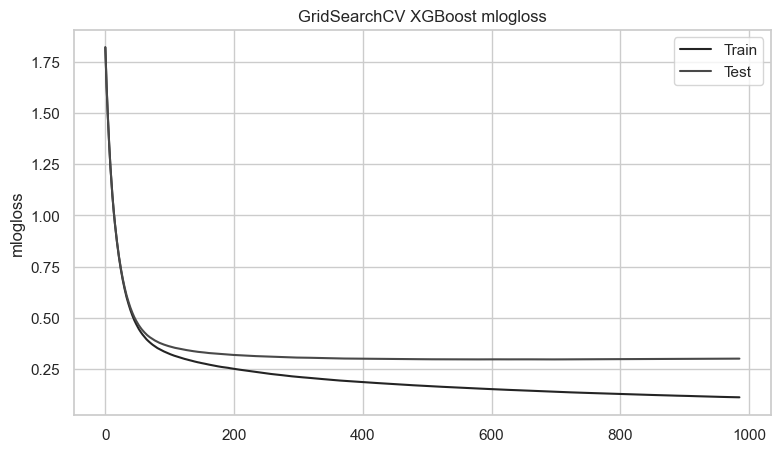

Final validation multi-class logarithmic loss: 0.3006178244683964


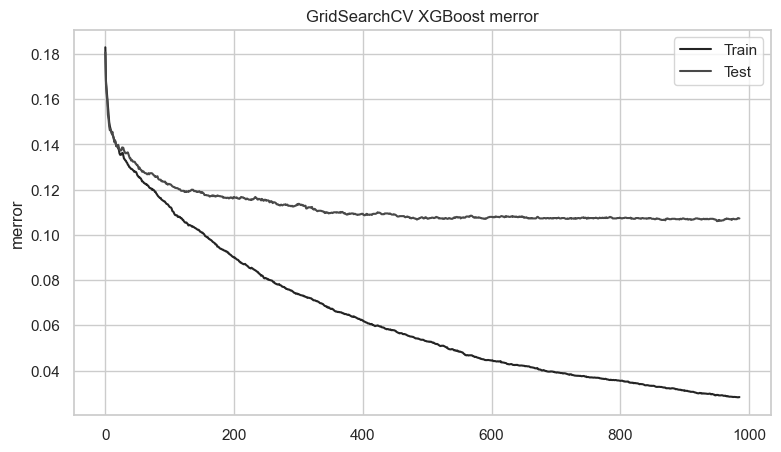

Final validation multi-class classification error rate: 0.10730632310561113


In [58]:
results = final_model.evals_result()                       # Retrieve evaluation results
epochs = len(results['validation_0']['mlogloss'])         # Number of training epochs
x_axis = range(0, epochs)                                  # Epoch indices for plotting

# Plot multi-class logarithmic loss (mlogloss) over epochs
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# Print final testing log loss
print(f"Final validation multi-class logarithmic loss: {results['validation_1']['mlogloss'][-1]}")

# Plot multi-class classification error rate (merror) over epochs
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

# Print final testing classification error rate
print(f"Final validation multi-class classification error rate: {results['validation_1']['merror'][-1]}")

### Predict on Test Set and Plot Confusion Matrix

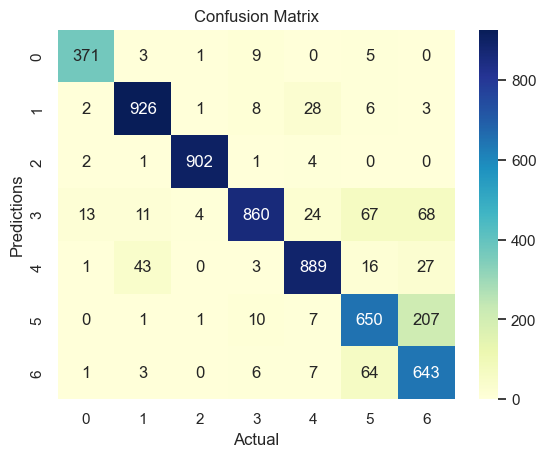

In [59]:
pred_test = model.predict(X_test)  # Predict labels on test data

# Compute confusion matrix: actual vs predicted for validation (likely intended)
cm = confusion_matrix(y_validate, pred_validate)  

# Plot confusion matrix heatmap with annotations
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='YlGnBu', 
    xticklabels=final_df['Type'].unique(),  # Actual classes on x-axis
    yticklabels=final_df['Type'].unique()   # Predicted classes on y-axis
)

plt.ylabel('Predictions')
plt.xlabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Classification Report for Test Set Predictions

In [60]:
# Print detailed metrics (precision, recall, f1-score, support) for test set predictions
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       349
           1       0.95      0.96      0.95      1036
           2       1.00      0.99      1.00       953
           3       0.92      0.84      0.87       995
           4       0.94      0.89      0.91      1014
           5       0.79      0.75      0.77       808
           6       0.70      0.87      0.78       744

    accuracy                           0.89      5899
   macro avg       0.89      0.89      0.89      5899
weighted avg       0.90      0.89      0.89      5899



Saving Trained Model

In [61]:
import joblib
# After training final_model
feature_order = list(X_train.columns)  
pd.DataFrame({"Feature": feature_order}).to_csv("new_feature_order.csv", index=False)

# Save the trained model
joblib.dump(final_model, "xgb_model.joblib")


print("Model and feature order saved!")


Model and feature order saved!
